In [48]:
#Imports
import covasim as cv
from datetime import date, timedelta

In [49]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

Initializing sim with 20000 people for 3 days
Initializing sim with 20000 people for 3 days
  Running "With beta changes": 2021-04-03 ( 0/3) (1.64 s)  •••••——————————————— 25%
  Running "Baseline": 2021-04-03 ( 0/3) (1.66 s)  •••••——————————————— 25%
Simulation "With beta changes" summary:
      23 cumulative infections
       8 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
       0 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people
Simulation "Baseline" summary:
      23 cumulative infections
       8 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
       0 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people




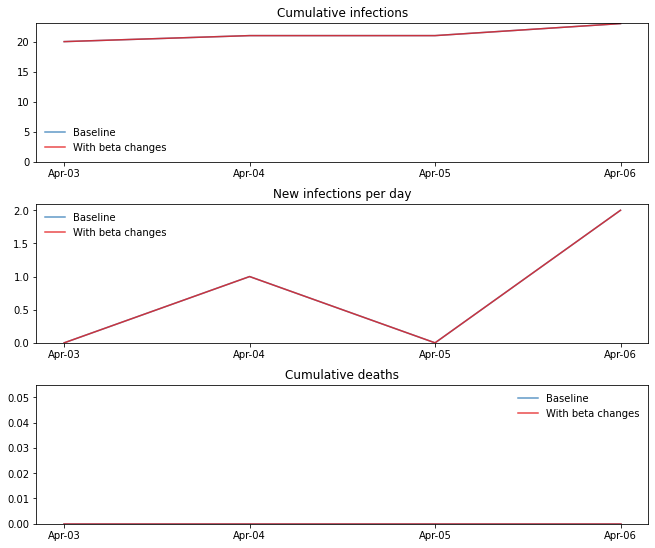

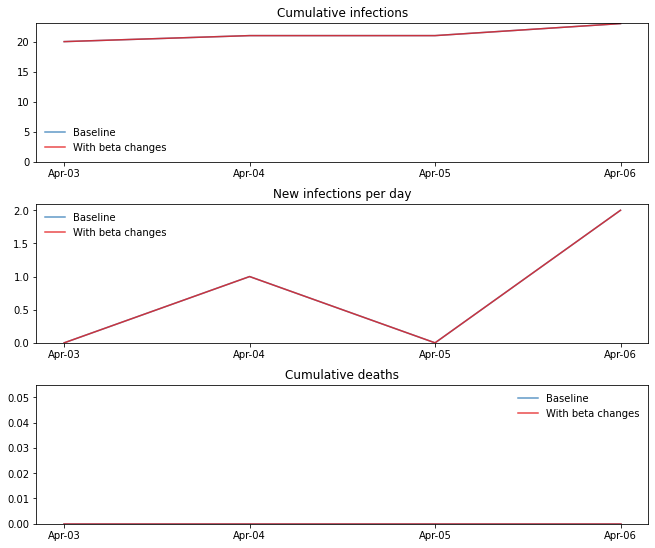

In [51]:
event_length = 3

d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length))

pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
)

event = cv.change_beta(days=['2020-03-15', '2020-03-16', '2020-03-17'], changes=[10.0, 10.0, 0])
orig_sim = cv.Sim(pars, interventions=event, label='Baseline')

# Define sim with change_beta
event_mitigate = cv.change_beta(days=['2020-03-15', '2020-03-16', '2020-03-17'], changes=[2.0, 2.0, 0])
sim = cv.Sim(pars, interventions=event_mitigate, label='With beta changes')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

